# 내가 관심있는 작가의 구독자들이 좋아하는 작가 추천

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import requests
import json
from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
## road pickle data
import pickle
pkl_file = open('/Users/goodvc/Data/fc-recsys-school/ch1/resource/brunch_sns.pkl', 'rb')
ds_dict = pickle.load(pkl_file)
pkl_file.close() 

In [3]:
ds_dict.keys()

['goodvc78']

In [4]:
## 관심 작가 정보 크롤링 하기 
## extract Brunch Writer Info : uid, name, text-count, megazine-count, follower-count, following-count:
def extractWriterInfo(uid):
    try:
        response = requests.get("http://brunch.co.kr/@{uid}".format(uid=uid) )
    except Exception:
        []
        
    data = response.content.decode('utf-8')
    soup = BeautifulSoup(data, 'html.parser')
    
    ## name 
    names = soup.find_all("strong", class_="profileUserName")
    name = uid if len(names)<1 else names[0].getText()
    
    classes = soup.find_all("span", class_="num_count")
    reserved = [uid, name]
    for c in classes:
        reserved.append(int(c.getText().replace(',','')))
    return reserved

#print extractWriterInfo('goodvc78')

In [5]:
def toDataframe(src) :
    data = []
    for n, f in src.items():
        for nn in f['following']:
            data.append([n,'following',nn])
    df = pd.DataFrame(data, columns=['uid','dir','target'])
    return df[~df.target.isin(['brunch'])]

In [6]:
df = toDataframe(ds_dict['goodvc78'])
df = df[~df.target.isin(['goodvc78','brunch'])]

### 상위 브런치 작가

In [7]:
## 상위 50 작가 선정 
topn=50
top_writer = df[df.dir=='following'].groupby('target').count().sort('uid', ascending=False)[:topn][['dir']]

top_writer = top_writer.reset_index()
top_writer.columns = ['uid','교차 구독자수']

## 상위 작가의 bruch 정보 가져오기 ( 크롤링 ) 
top_writer_info = []
for uid in top_writer.uid:
    top_writer_info.append(extractWriterInfo(uid))
top_writer_info = pd.DataFrame(top_writer_info, columns=['uid','작가명','글 수', '매거진수', '비교작가 구독자수', '관심작가수' ])

In [8]:
top_writer_info.head()

,uid,작가명,글 수,매거진수,비교작가 구독자수,관심작가수
0,lifidea,Jin Young Kim,11,1,819,195
1,brunchflgu,조우성 변호사,682,10,5365,36
2,jimmyrim,임지훈 Jimmy Rim,6,0,2487,0
3,yoojs8512,유재석,46,1,1484,24
4,insuk,조인석 chris,10,1,956,29


In [9]:
## 데이터 머지 
top_writer = pd.merge(top_writer, top_writer_info, on=['uid'])

In [10]:
top_writer.head()

,uid,교차 구독자수,작가명,글 수,매거진수,비교작가 구독자수,관심작가수
0,lifidea,56,Jin Young Kim,11,1,819,195
1,brunchflgu,44,조우성 변호사,682,10,5365,36
2,jimmyrim,42,임지훈 Jimmy Rim,6,0,2487,0
3,yoojs8512,40,유재석,46,1,1484,24
4,insuk,39,조인석 chris,10,1,956,29


In [11]:
top_writer['관심작가 구독자수'] = len(ds_dict['goodvc78'].keys())

In [12]:
top_writer.head()

,uid,교차 구독자수,작가명,글 수,매거진수,비교작가 구독자수,관심작가수,관심작가 구독자수
0,lifidea,56,Jin Young Kim,11,1,819,195,169
1,brunchflgu,44,조우성 변호사,682,10,5365,36,169
2,jimmyrim,42,임지훈 Jimmy Rim,6,0,2487,0,169
3,yoojs8512,40,유재석,46,1,1484,24,169
4,insuk,39,조인석 chris,10,1,956,29,169


In [13]:
## 전체 구독수대비 나의 구독자수 비율
top_writer['교차 구독자수 비율'] = top_writer['교차 구독자수'] \
    / (top_writer['비교작가 구독자수'] + top_writer['관심작가 구독자수'] - top_writer['교차 구독자수']  )

top_writer['교차 구독자수 비율'] = top_writer['교차 구독자수 비율'].apply(lambda x: round(x,3))

In [14]:
top_writer.head()

,uid,교차 구독자수,작가명,글 수,매거진수,비교작가 구독자수,관심작가수,관심작가 구독자수,교차 구독자수 비율
0,lifidea,56,Jin Young Kim,11,1,819,195,169,0.060
1,brunchflgu,44,조우성 변호사,682,10,5365,36,169,0.008
2,jimmyrim,42,임지훈 Jimmy Rim,6,0,2487,0,169,0.016
3,yoojs8512,40,유재석,46,1,1484,24,169,0.025
4,insuk,39,조인석 chris,10,1,956,29,169,0.036


In [15]:
def rankBy( ds, colname, topn=10 ):
    ranked = ds.sort(colname, ascending=False)[['uid','작가명','관심작가 구독자수', '교차 구독자수','비교작가 구독자수', '교차 구독자수 비율']][:topn]
    for (name,row) in ranked.iterrows():
        print ("https://brunch.co.kr/@{name}".format(name=row['uid'], value=row['작가명']))
    return ranked
#rankBy( top_writer, '나의 구독자수')

In [16]:
rankBy( top_writer, '교차 구독자수')

https://brunch.co.kr/@lifidea
https://brunch.co.kr/@brunchflgu
https://brunch.co.kr/@jimmyrim
https://brunch.co.kr/@yoojs8512
https://brunch.co.kr/@insuk
https://brunch.co.kr/@suyoung
https://brunch.co.kr/@suhanjang
https://brunch.co.kr/@breakthrough
https://brunch.co.kr/@pelexus
https://brunch.co.kr/@wjchee


,uid,작가명,관심작가 구독자수,교차 구독자수,비교작가 구독자수,교차 구독자수 비율
0,lifidea,Jin Young Kim,169,56,819,0.060
1,brunchflgu,조우성 변호사,169,44,5365,0.008
2,jimmyrim,임지훈 Jimmy Rim,169,42,2487,0.016
3,yoojs8512,유재석,169,40,1484,0.025
4,insuk,조인석 chris,169,39,956,0.036
5,suyoung,강수영,169,33,1286,0.023
6,suhanjang,티거 Jang,169,32,5209,0.006
7,breakthrough,한국현,169,28,1421,0.018
8,pelexus,최윤섭,169,28,832,0.029
9,wjchee,지원준,169,28,496,0.044


In [17]:
rankBy( top_writer, '비교작가 구독자수')

https://brunch.co.kr/@brunchflgu
https://brunch.co.kr/@suhanjang
https://brunch.co.kr/@rothem
https://brunch.co.kr/@haneulalice
https://brunch.co.kr/@jimmyrim
https://brunch.co.kr/@2kija
https://brunch.co.kr/@sooscape
https://brunch.co.kr/@yoonash
https://brunch.co.kr/@yoojs8512
https://brunch.co.kr/@sshong


,uid,작가명,관심작가 구독자수,교차 구독자수,비교작가 구독자수,교차 구독자수 비율
1,brunchflgu,조우성 변호사,169,44,5365,0.008
6,suhanjang,티거 Jang,169,32,5209,0.006
37,rothem,Rothem,169,17,2698,0.006
11,haneulalice,Alice in wonderland,169,27,2598,0.010
2,jimmyrim,임지훈 Jimmy Rim,169,42,2487,0.016
18,2kija,이기주작가,169,22,2407,0.009
12,sooscape,흔디,169,26,1777,0.014
15,yoonash,yoonash,169,25,1491,0.015
3,yoojs8512,유재석,169,40,1484,0.025
17,sshong,홍순성,169,24,1441,0.015


In [18]:
rankBy( top_writer, '교차 구독자수 비율')

https://brunch.co.kr/@cojette
https://brunch.co.kr/@chaibschaibs
https://brunch.co.kr/@lifidea
https://brunch.co.kr/@cloud09
https://brunch.co.kr/@wjchee
https://brunch.co.kr/@yannheo
https://brunch.co.kr/@manya
https://brunch.co.kr/@yper
https://brunch.co.kr/@techhtml
https://brunch.co.kr/@jaeseungmun


,uid,작가명,관심작가 구독자수,교차 구독자수,비교작가 구독자수,교차 구독자수 비율
16,cojette,cojette,169,24,110,0.094
32,chaibschaibs,CHAIBS,169,18,128,0.065
0,lifidea,Jin Young Kim,169,56,819,0.060
33,cloud09,강한별,169,18,175,0.055
9,wjchee,지원준,169,28,496,0.044
29,yannheo,허양일,169,19,295,0.043
22,manya,마냐,169,21,346,0.043
20,yper,문현구 YPER 대표,169,21,358,0.042
40,techhtml,조 은,169,16,233,0.041
43,jaeseungmun,Jaeseung Mun,169,15,219,0.040


---



# 브런치 작가 Clustering


In [19]:
from scipy.spatial import distance 
from scipy import stats
import seaborn as sns
import scipy

def cos_cdist(matrix, vector, dist):
    """
    Compute the cosine distances between each row of matrix and vector.
    """
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

def matrix_similarity( matrix_ds, dist='jaccard'):
    
    sim_mat = []
    name = []
    for idx, row in matrix_ds.iterrows():
        name.append(idx)
        sim_mat.append(cos_cdist( matrix_ds, row, dist ).tolist())
    ds = 1-pd.DataFrame(sim_mat, columns=name, index=name)
    return ds

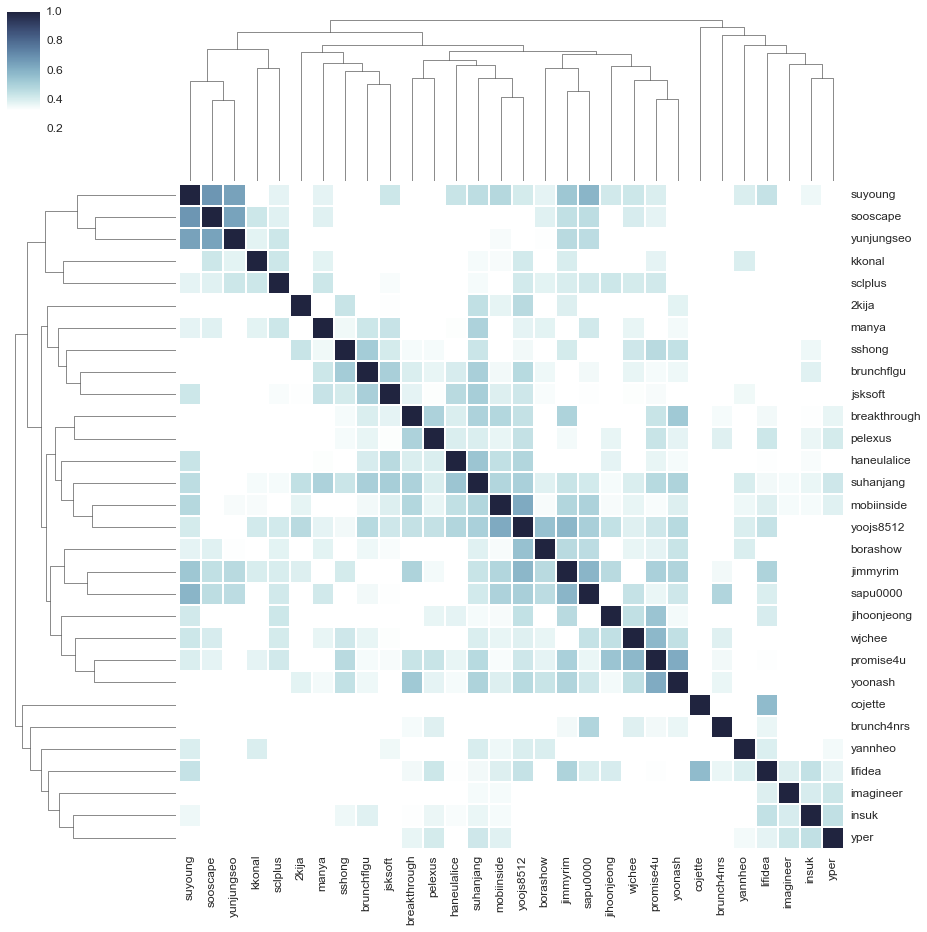

In [20]:
## data 만들기
tmp_ds = df[df.target.isin(top_writer[:30].uid)]
writer_ds = pd.pivot_table( tmp_ds, index='target', columns='uid', values='dir', aggfunc=len, fill_value=0)
ds = matrix_similarity( writer_ds )

## 테마 셋팅
sns.set(style="whitegrid", palette="pastel", color_codes=True,font_scale=1.2)
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.2, light=1.3)

## clustering & visualization
cm = sns.clustermap(ds, cmap=cmap, linewidths=.5)

## figure size 
cm.fig.set_figwidth(15)
cm.fig.set_figheight(15)

In [21]:
for idx,row in top_writer[:30].sort('uid').iterrows():
    print( u"https://brunch.co.kr/@{uid} {name}".format(uid=row.uid, name=row['작가명']))

https://brunch.co.kr/@2kija 이기주작가
https://brunch.co.kr/@borashow 보라쇼
https://brunch.co.kr/@breakthrough 한국현
https://brunch.co.kr/@brunch4nrs 윤청하
https://brunch.co.kr/@brunchflgu 조우성 변호사
https://brunch.co.kr/@cojette cojette
https://brunch.co.kr/@haneulalice Alice in wonderland
https://brunch.co.kr/@imagineer 더할 나위 없이
https://brunch.co.kr/@insuk 조인석 chris
https://brunch.co.kr/@jihoonjeong 정지훈
https://brunch.co.kr/@jimmyrim 임지훈 Jimmy Rim
https://brunch.co.kr/@jsksoft 상상
https://brunch.co.kr/@kkonal 꼬날
https://brunch.co.kr/@lifidea Jin Young Kim
https://brunch.co.kr/@manya 마냐
https://brunch.co.kr/@mobiinside Mobiinside
https://brunch.co.kr/@pelexus 최윤섭
https://brunch.co.kr/@promise4u 양준철
https://brunch.co.kr/@sapu0000 송준협
https://brunch.co.kr/@sclplus 엄지용
https://brunch.co.kr/@sooscape 흔디
https://brunch.co.kr/@sshong 홍순성
https://brunch.co.kr/@suhanjang 티거 Jang
https://brunch.co.kr/@suyoung 강수영
https://brunch.co.kr/@wjchee 지원준
https://brunch.co.kr/@yannheo 허양일
https://brunch.co.kr/@yoojs85

### 클러스터 1번
UX, 디자인 관련 글이 주를 이루는 UX,디자인,기획을 업으로 하시는 작가분
* https://brunch.co.kr/@yunjungseo Yunjung Seo
* https://brunch.co.kr/@hmin0606 신유민 
* https://brunch.co.kr/@suyoung 강수영
* https://brunch.co.kr/@meanimize Meanimize
* https://brunch.co.kr/@sooscape 흔디
* https://brunch.co.kr/@sapu0000 송준협
---
### 클러스터 2번
개발자 문화에 관련된 글이 주를 이루는 개발을 업으로하시는 작가분(대체적으로 글수가 10개 이하로 적음)
* https://brunch.co.kr/@brunch4nrs 윤청하
* https://brunch.co.kr/@brunchlftm sbroh
* https://brunch.co.kr/@insuk 조인석 chris
* https://brunch.co.kr/@pelexus 최윤섭
---
### 클러스터 3번
스타트업 문화, 회사의 생활, 직무, 업무 멘토링 등과 관련된 글이 많은 작가분들임
* https://brunch.co.kr/@promise4u 양준철
* https://brunch.co.kr/@yoonash yoonash
* https://brunch.co.kr/@aboutheman 퀘벤하운
* https://brunch.co.kr/@aboutheman 퀘벤하운
* https://brunch.co.kr/@jihoonjeong 정지훈
* https://brunch.co.kr/@haneulalice Alice in wonderland
* https://brunch.co.kr/@suhanjang 티거 Jang
---
### 클러스터 4번
IT 트랜드, 컬럼, 사회 현상에 대한 내용을 담은 작가분들임
* https://brunch.co.kr/@sclplus 엄지용
* https://brunch.co.kr/@wjchee 지원준
* https://brunch.co.kr/@jsksoft 상상
* https://brunch.co.kr/@borashow 보라쇼
* https://brunch.co.kr/@manya 마냐
---
### 클러스터 5번
4번 클러스터와 유사하게 IT/모바일 트렌드, 데이터과학 등 저널의 성향이 있는 작가분들임
* https://brunch.co.kr/@genie7pe Chulhyun Cho
* https://brunch.co.kr/@jaeseungmun Jaeseung Mun
* https://brunch.co.kr/@sapu0000 송준협
* https://brunch.co.kr/@jimmyrim 임지훈 Jimmy Rim
* https://brunch.co.kr/@mobiinside Mobiinside
* https://brunch.co.kr/@yoojs8512 유재석
* https://brunch.co.kr/@lifidea Jin Young Kim


--- 
# 다양한 작가들과 함께분석 

### 작가를 벡터 공간에 임베딩하기 

In [22]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import rcParams
from datetime import datetime
import gensim, logging
import random
%matplotlib inline  

rcParams['font.family'] = 'AppleGothic'
rcParams.update({'font.size': 14})

In [23]:
## road pickle data

pkl_file = open('/Users/goodvc/Data/fc-recsys-school/ch1/resource/brunch_sns.pkl', 'rb')
writers_dict = pickle.load(pkl_file)
pkl_file.close() 

In [24]:
for id in writers_dict.keys():
    print("https://brunch.co.kr/@{0}".format(id))

https://brunch.co.kr/@goodvc78


In [25]:
# word2vec으로 학습할 corpus 만들기 
corpus = []
for owner, folloings in writers_dict.items():
    #if owner != 'goodvc78':
    #    continue
    corpus = corpus + [ f['following']  for n, f in folloings.items() ] 

In [26]:
import gensim, logging
model = gensim.models.Word2Vec(corpus, min_count=10,size=100, window=10)

In [27]:
print (u"작가수 %d" % model.syn0.shape[0])

작가수 106


In [28]:
for id, sim in model.most_similar(positive=['goodvc78'],topn=20):
    print( "{1}   https://brunch.co.kr/@{0}".format(id, sim)) 

0.942379653454   https://brunch.co.kr/@techsuda
0.940222382545   https://brunch.co.kr/@2kija
0.940101981163   https://brunch.co.kr/@aboutheman
0.935606122017   https://brunch.co.kr/@sclplus
0.931997299194   https://brunch.co.kr/@wjchee
0.931395053864   https://brunch.co.kr/@jimmyrim
0.930869519711   https://brunch.co.kr/@hyejinchoi
0.930641889572   https://brunch.co.kr/@sapu0000
0.930432081223   https://brunch.co.kr/@yongjinjinipln
0.930242359638   https://brunch.co.kr/@suhanjang
0.929644703865   https://brunch.co.kr/@lifidea
0.929575562477   https://brunch.co.kr/@jsksoft
0.928601026535   https://brunch.co.kr/@suyoung
0.927403688431   https://brunch.co.kr/@yoonash
0.927266120911   https://brunch.co.kr/@kwihun80
0.925093531609   https://brunch.co.kr/@futureagent
0.924409151077   https://brunch.co.kr/@yoojs8512
0.924275815487   https://brunch.co.kr/@bang1999
0.923784136772   https://brunch.co.kr/@manya
0.923367500305   https://brunch.co.kr/@minieetea
